Imports

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from scipy.stats.mstats import winsorize
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

np.random.seed(42) #Sets the random seed. 

**A place to put some functions used throughout the notebook.**

In [5]:
# Function to print a summary from dataframes. Adds skewness and kurtosis values. 
def see_summary (data_frame):
    summary = data_frame.describe(include='all').T
    summary['skewness'] = data_frame.skew()
    summary['kurtosis'] = data_frame.kurtosis()
    print(summary)

# Function to plot Distributions
def distribution (df_column, column_name):
    plt.hist(df_column,bins=25)
    plt.title(f"Histogram of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.show()

***Loading in Data and Getting the Summary Statistics***
Dropping Time_Value and Smoothed_wtested_positive_14d columns

In [7]:
# print(os.getcwd())
df = pd.read_csv('covidcast_new-1.csv')
# print (df.head())

if "time_value" in df.columns:
    df = df.drop('time_value', axis=1)

# see_summary(df)

# Dropping rows w/o the target label. 
df = df[df['smoothed_wtested_positive_14d'].notnull()]

see_summary(df)

# Checking for empty values. 
empty = df.isnull().sum()
# print(empty) 
percent_null = (empty / len(df)) * 100
null_summary = pd.DataFrame({'Null Count': empty, 'Percent Null': percent_null})
print(null_summary)

                                       count          mean           std  \
geo_value                             3994.0  26665.803205  15971.575875   
smoothed_wspent_time_1d               3873.0     29.540826      6.165547   
smoothed_wtested_14d                  3879.0     15.685206      5.090793   
smoothed_wpublic_transit_1d           3873.0      3.955646      5.141994   
smoothed_wworried_become_ill          3903.0     70.512220      5.402762   
smoothed_wvaccine_likely_govt_health  3903.0     32.974395      7.484255   
smoothed_wshop_1d                     3873.0     52.650528      4.830845   
smoothed_wtested_positive_14d         3994.0     17.250770      7.419522   
smoothed_wwork_outside_home_1d        3873.0     31.864066      5.510357   
smoothed_wothers_masked               3899.0     82.046408     13.480812   
smoothed_wcli                         3859.0      1.061285      0.508627   
smoothed_wcovid_vaccinated            3894.0     12.434098      6.143912   
smoothed_wva

Making Histograms for each column in the data frame.

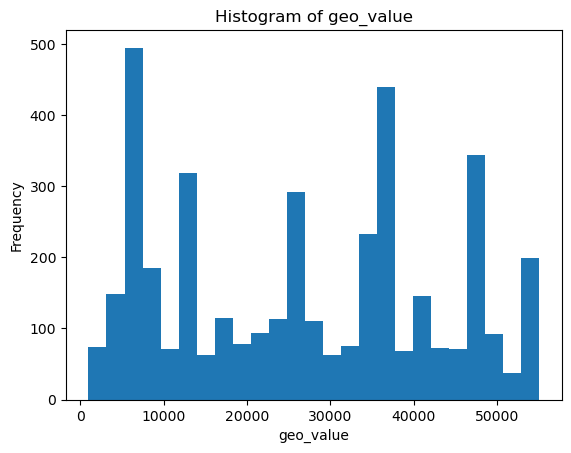

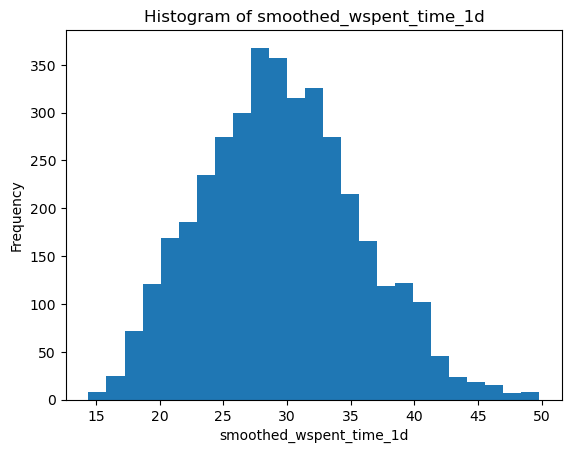

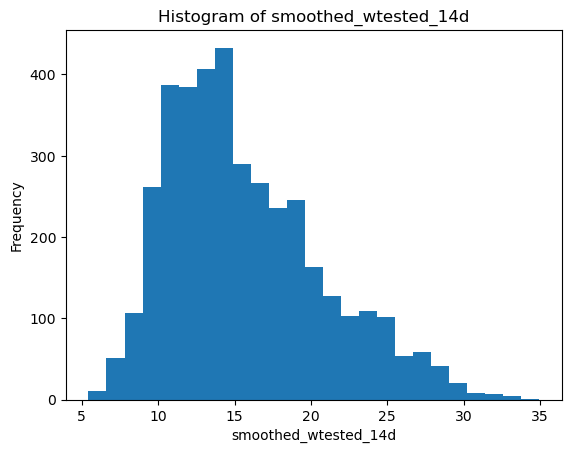

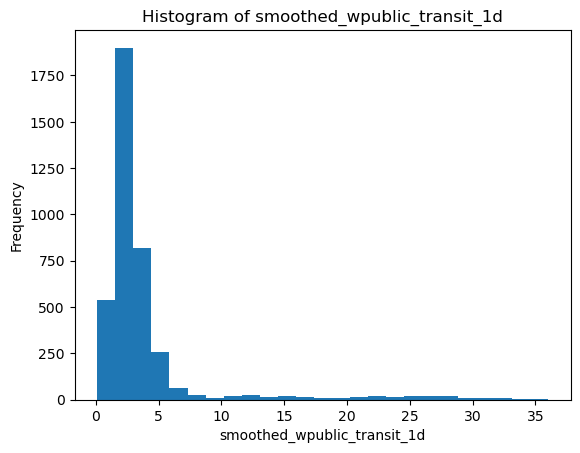

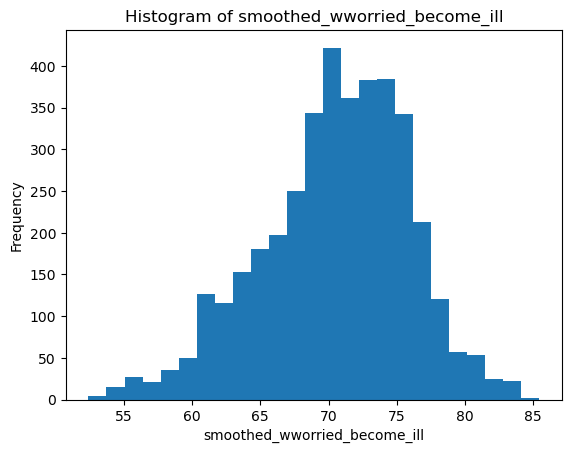

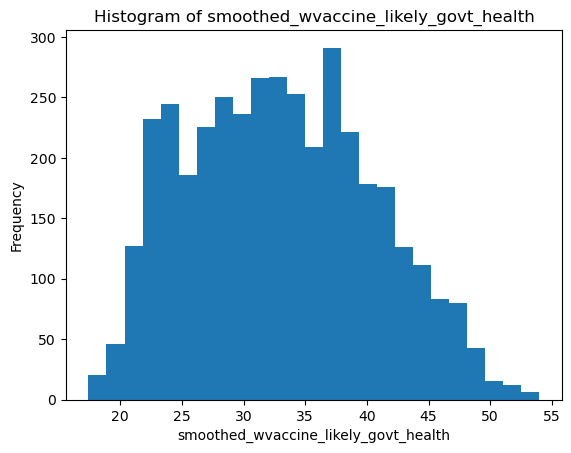

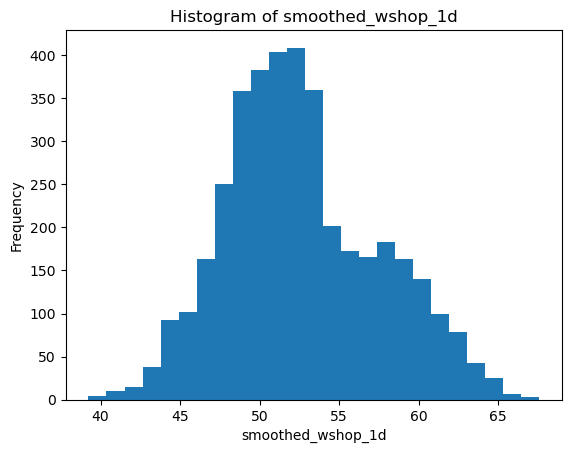

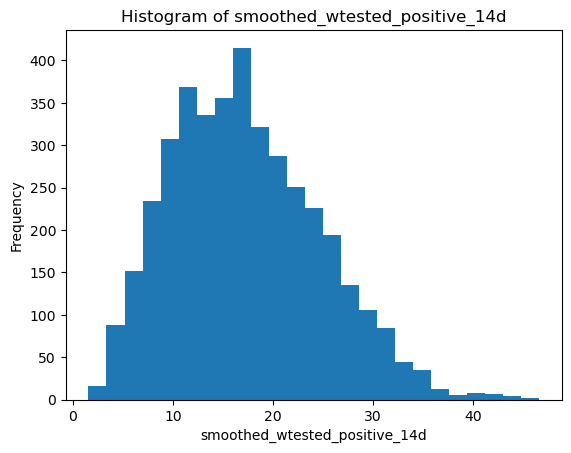

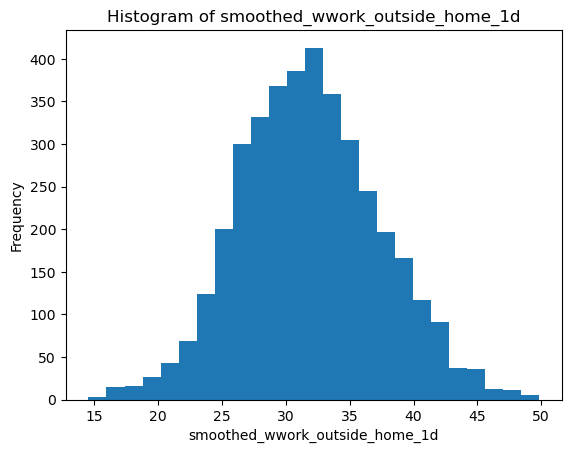

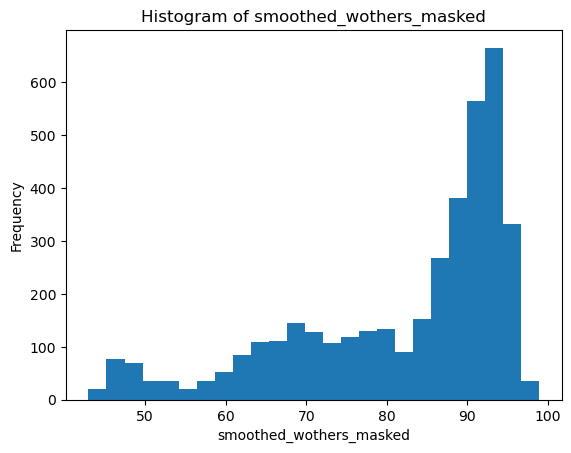

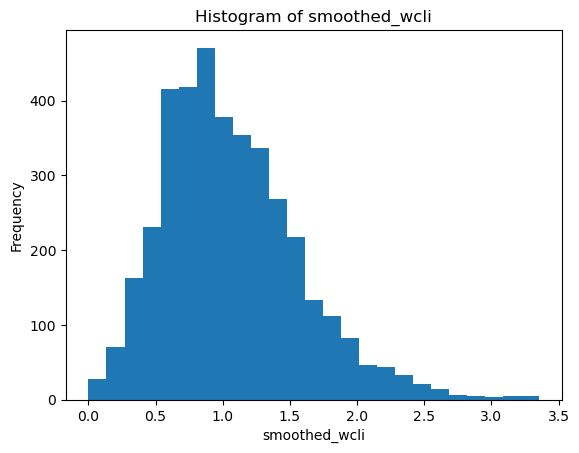

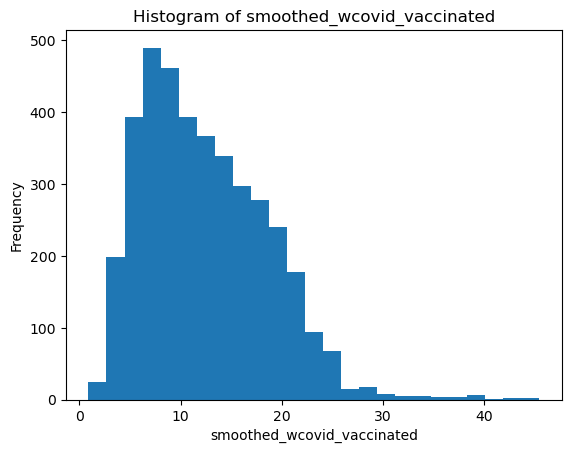

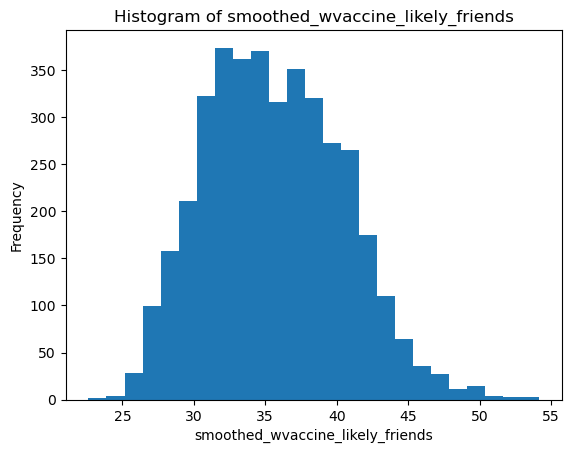

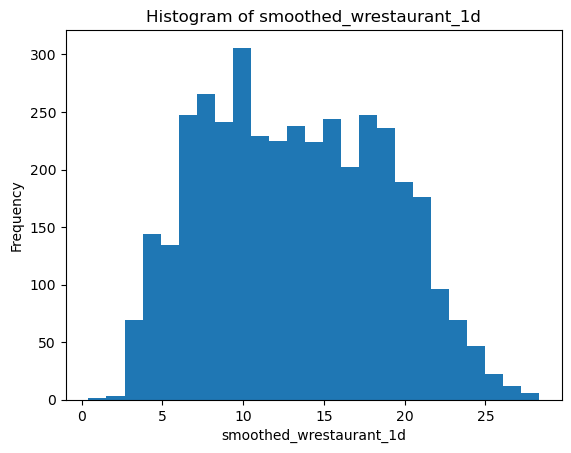

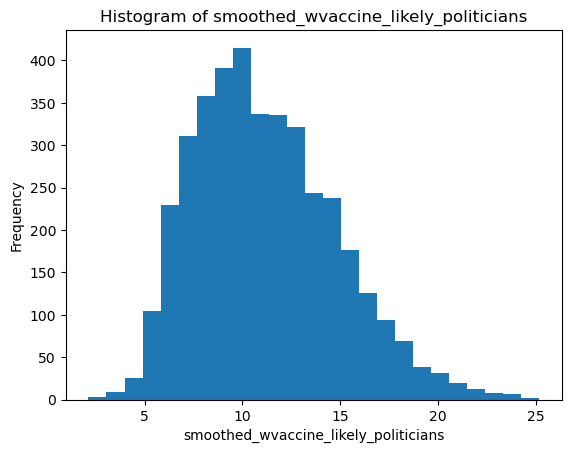

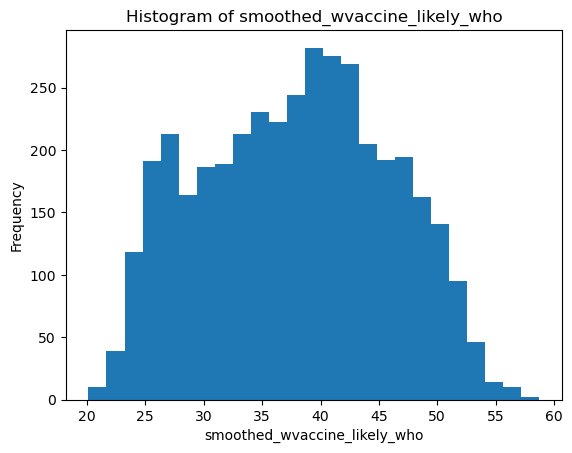

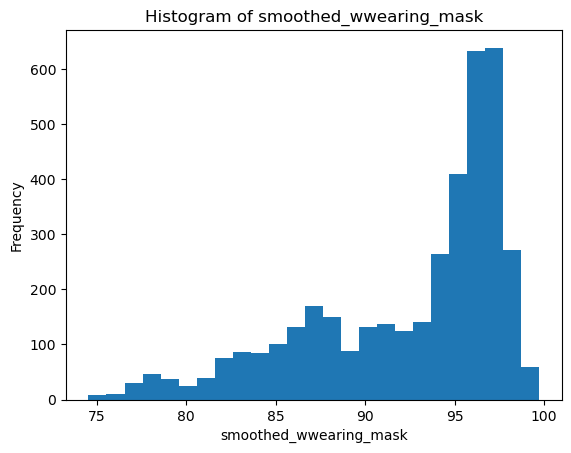

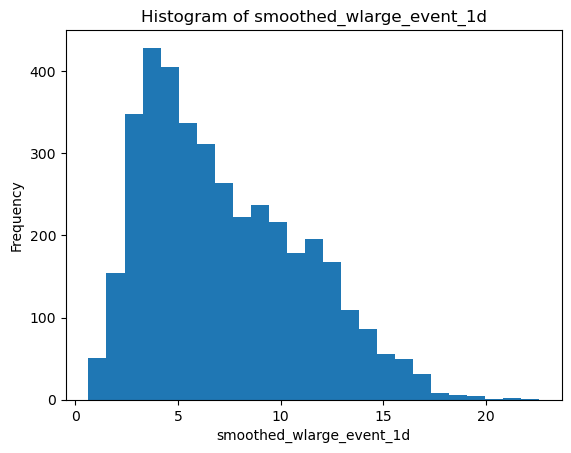

In [9]:
for col in df.columns:
    distribution(df[col], col)

**Removing Geo_Value from the data frame.** 

In [11]:
# Drop Geo_Value
if "geo_value" in df.columns:  
    df = df.drop('geo_value', axis=1)

# print (df.columns)

Visualize a correlation matrix

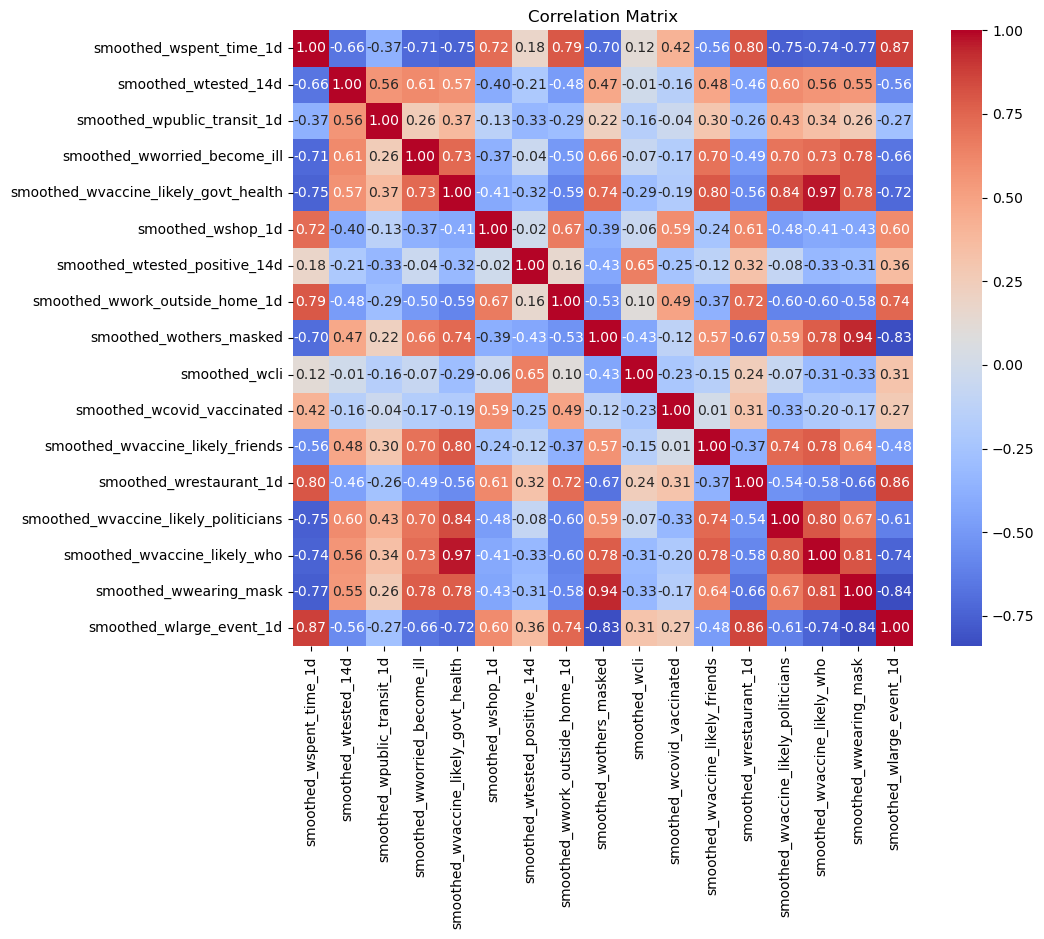

In [13]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Now, looking at dropping unreliable instances in the dataset. Set the threshold to 51% So anything less would be dropped.  

In [15]:
# Testing the threshold feature here. 
threshold = df.shape[1] * 0.51
print (threshold)
print(len(df))
df_test = df.dropna(thresh=threshold)
print(len(df_test))

8.67
3994
3881


In [16]:
df= df.dropna(thresh=threshold)

see_summary(df)

                                       count       mean        std        min  \
smoothed_wspent_time_1d               3873.0  29.540826   6.165547  14.410554   
smoothed_wtested_14d                  3878.0  15.683821   5.090718   5.437303   
smoothed_wpublic_transit_1d           3873.0   3.955646   5.141994   0.115497   
smoothed_wworried_become_ill          3878.0  70.490606   5.395952  52.405818   
smoothed_wvaccine_likely_govt_health  3877.0  32.970862   7.493678  17.410006   
smoothed_wshop_1d                     3873.0  52.650528   4.830845  39.237833   
smoothed_wtested_positive_14d         3881.0  17.417078   7.426650   1.548609   
smoothed_wwork_outside_home_1d        3873.0  31.864066   5.510357  14.558697   
smoothed_wothers_masked               3877.0  81.978574  13.484213  42.950717   
smoothed_wcli                         3858.0   1.061560   0.508406   0.000000   
smoothed_wcovid_vaccinated            3879.0  12.459743   6.141449   0.891041   
smoothed_wvaccine_likely_fri

Filling in missing values using a normal distribution if we can assume normality when examining kurtosis and skewness. If not using the median value instead of the mean to fill the value.  

In [18]:
for col in df.columns:
    if df[col].skew() > 1 or df[col].skew() < -1 or df[col].kurtosis() > 3 or df[col].kurtosis() < 0: #Indicates not normally distributed.Use median to fill missing values. 
        if df[col].isnull().any():
            median = df[col].median()
            std = df[col].std()
            num_missing = df[col].isnull().sum()
            random_values = np.random.normal(loc=median, scale=std, size=num_missing)
            df.loc[df[col].isnull(), col] = random_values
    else: 
        if df[col].isnull().any():
            mean = df[col].mean()
            std = df[col].std()
            num_missing = df[col].isnull().sum()
            random_values = np.random.normal(loc=mean, scale=std, size=num_missing)
            df.loc[df[col].isnull(), col] = random_values

# print(df.isnull().sum()) # A check to ensure there are no missing values in the dataset. 

In [19]:
see_summary(df)

                                       count       mean        std        min  \
smoothed_wspent_time_1d               3881.0  29.547202   6.163782  14.410554   
smoothed_wtested_14d                  3881.0  15.683309   5.089229   5.437303   
smoothed_wpublic_transit_1d           3881.0   3.944756   5.145345  -7.289100   
smoothed_wworried_become_ill          3881.0  70.490366   5.396782  52.405818   
smoothed_wvaccine_likely_govt_health  3881.0  32.967158   7.492192  17.410006   
smoothed_wshop_1d                     3881.0  52.647410   4.830428  39.237833   
smoothed_wtested_positive_14d         3881.0  17.417078   7.426650   1.548609   
smoothed_wwork_outside_home_1d        3881.0  31.860306   5.510784  14.558697   
smoothed_wothers_masked               3881.0  81.975541  13.479502  42.950717   
smoothed_wcli                         3881.0   1.061778   0.507946   0.000000   
smoothed_wcovid_vaccinated            3881.0  12.459294   6.140299   0.891041   
smoothed_wvaccine_likely_fri

***Now, transforming the columns to make them approximately normal for our models.***

In [21]:
scalar = MinMaxScaler()
robust = RobustScaler()

for col in df.columns:
    if col == 'smoothed_wpublic_transit_1d':
        min_val = df['smoothed_wpublic_transit_1d'].min()
        shift_amount = abs(min_val) + 0.1 # Making the values non-negative before using the log function here. 
        df['smoothed_wpublic_transit_1d'] = np.log1p(df['smoothed_wpublic_transit_1d'] + shift_amount)
        df['smoothed_wpublic_transit_1d'] = winsorize(df['smoothed_wpublic_transit_1d'], limits=[0.01, 0.065]) #Winsorizing the data is a bit extreme but it caps all the outliers from this feature.
        df[['smoothed_wpublic_transit_1d']] = robust.fit_transform(df[['smoothed_wpublic_transit_1d']] )  
    elif df[col].skew() > 1 or df[col].skew() < -1:
        if df[col].kurtosis() > 3 or df[col].kurtosis() < 0:
            df[col] = np.log1p(df[col] - df[col].min() + 1)
        df[[col]] = scalar.fit_transform(df[[col]])

see_summary(df)

                                       count       mean       std        min  \
smoothed_wspent_time_1d               3881.0  29.547202  6.163782  14.410554   
smoothed_wtested_14d                  3881.0  15.683309  5.089229   5.437303   
smoothed_wpublic_transit_1d           3881.0   0.300209  1.147643  -1.299343   
smoothed_wworried_become_ill          3881.0  70.490366  5.396782  52.405818   
smoothed_wvaccine_likely_govt_health  3881.0  32.967158  7.492192  17.410006   
smoothed_wshop_1d                     3881.0  52.647410  4.830428  39.237833   
smoothed_wtested_positive_14d         3881.0  17.417078  7.426650   1.548609   
smoothed_wwork_outside_home_1d        3881.0  31.860306  5.510784  14.558697   
smoothed_wothers_masked               3881.0   0.697056  0.240769   0.000000   
smoothed_wcli                         3881.0   1.061778  0.507946   0.000000   
smoothed_wcovid_vaccinated            3881.0  12.459294  6.140299   0.891041   
smoothed_wvaccine_likely_friends      38

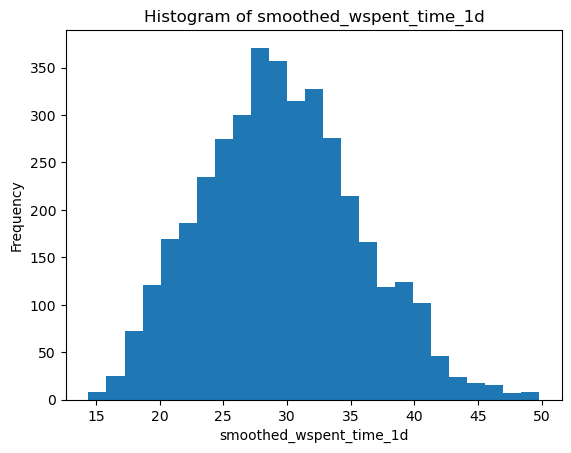

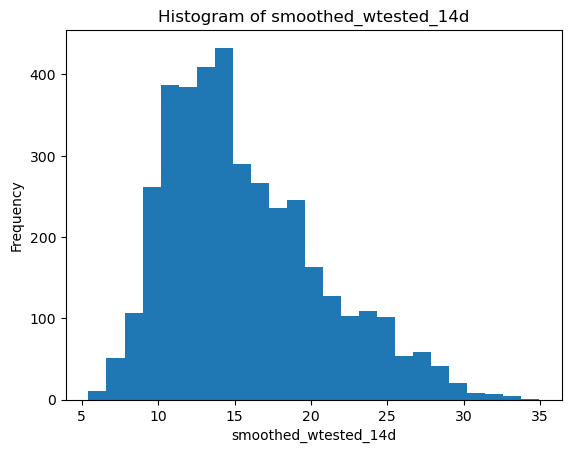

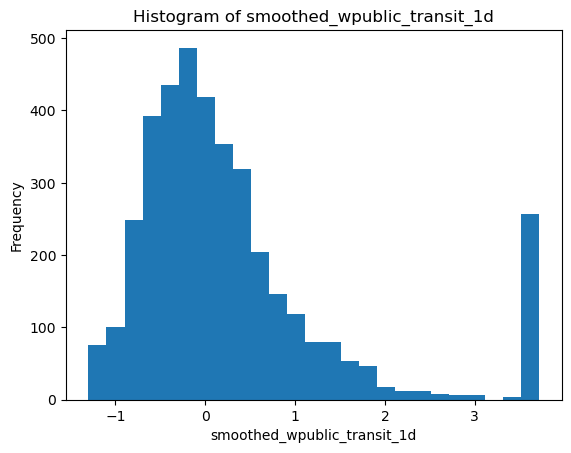

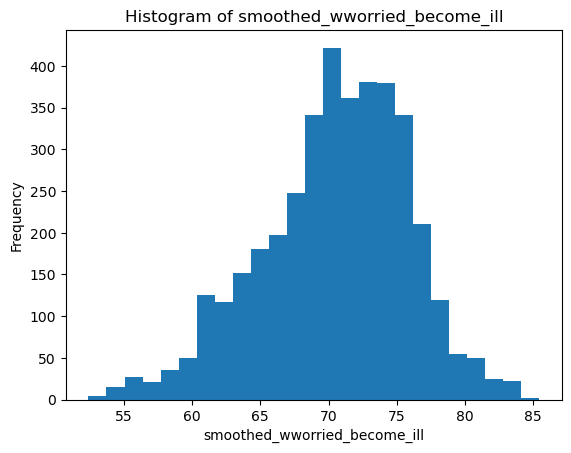

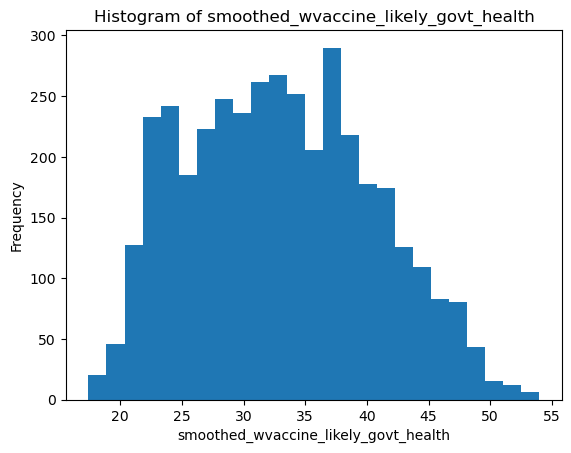

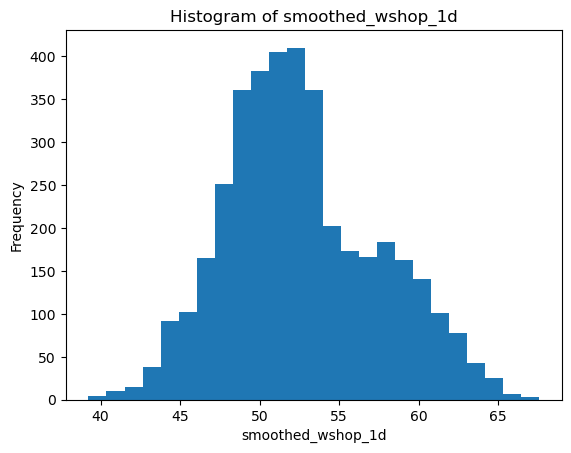

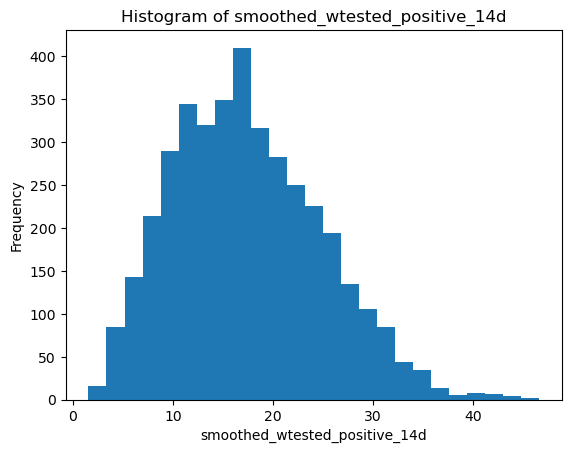

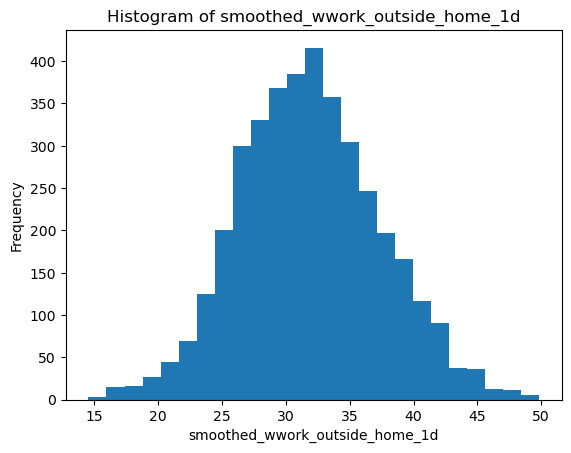

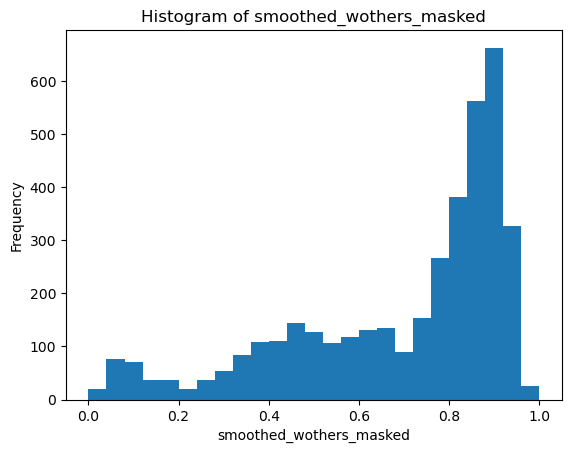

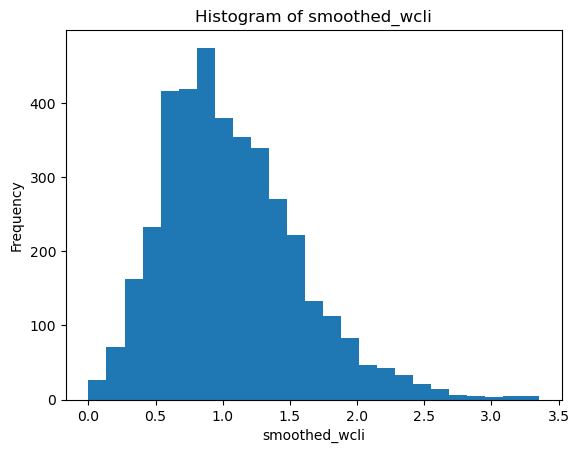

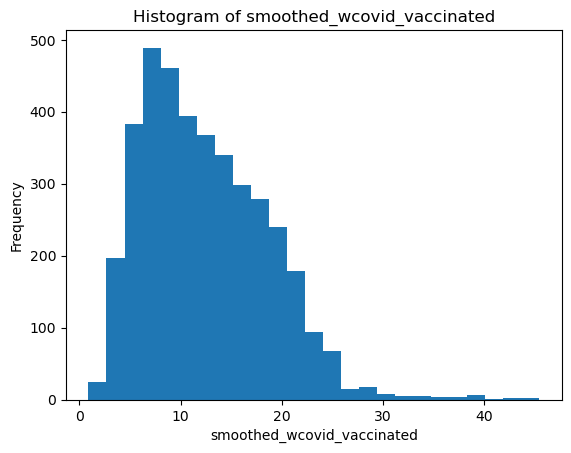

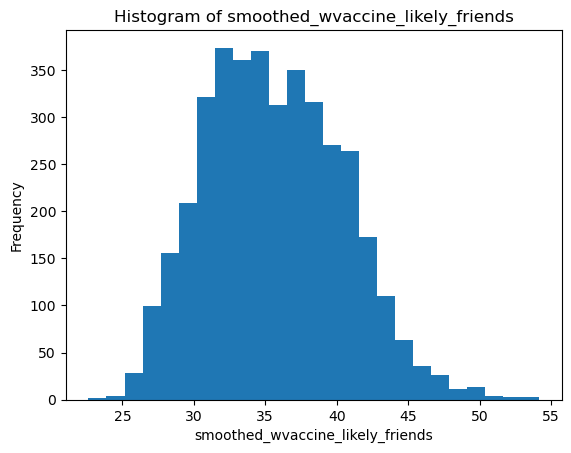

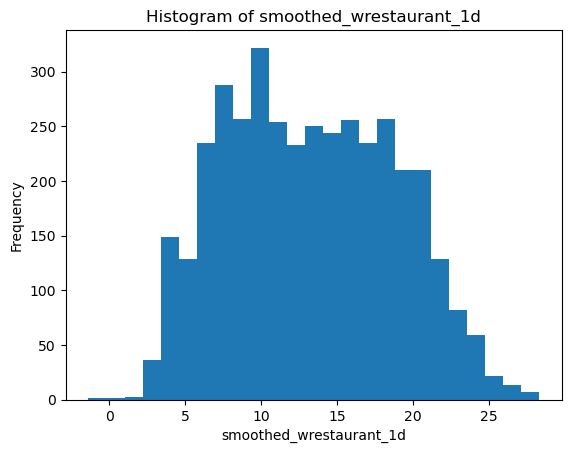

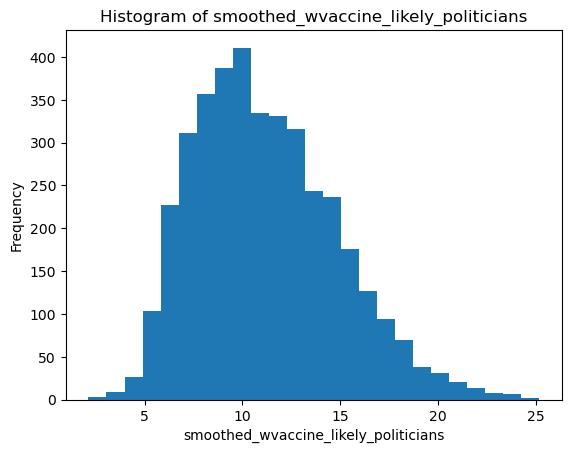

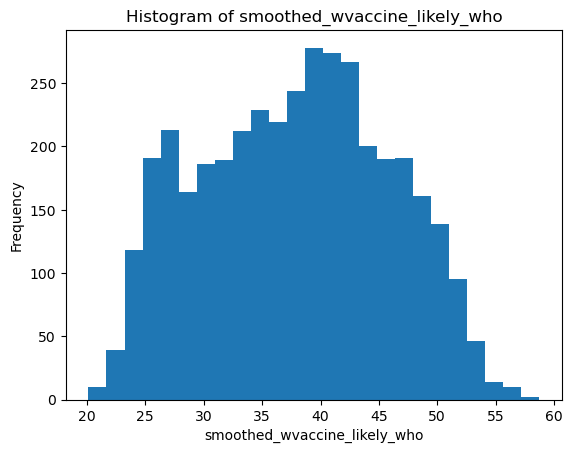

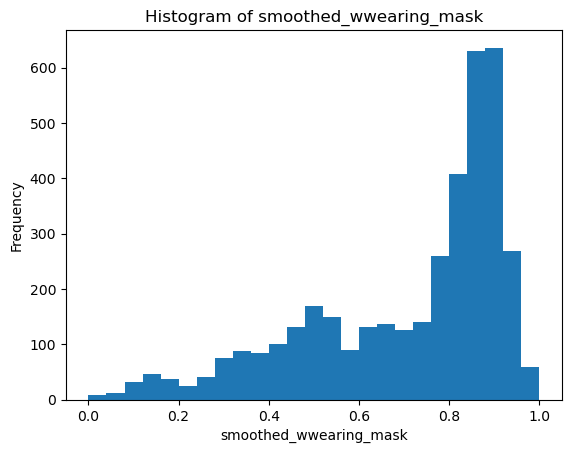

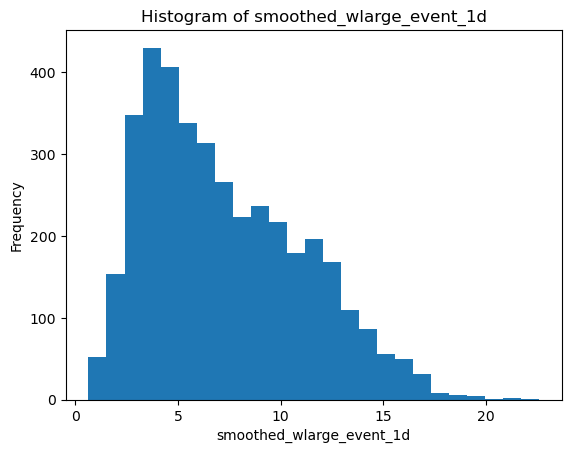

In [22]:
for col in df.columns:
    distribution(df[col], col)

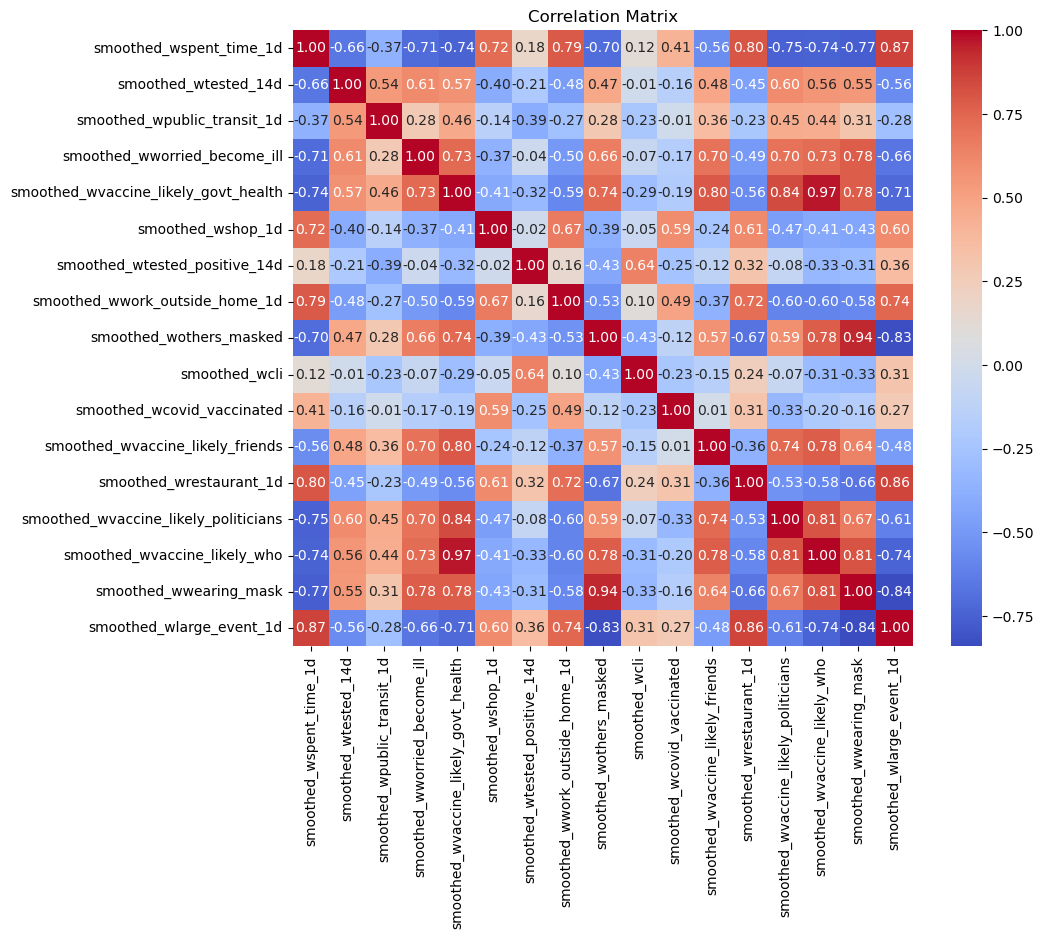

In [23]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


Variance Inflation Factor (VIF):
                                 Feature         VIF
14          smoothed_wvaccine_likely_who  487.872251
4   smoothed_wvaccine_likely_govt_health  459.513086
3           smoothed_wworried_become_ill  451.506093
5                      smoothed_wshop_1d  332.463854
11      smoothed_wvaccine_likely_friends  224.904295
0                smoothed_wspent_time_1d  213.990810
15                smoothed_wwearing_mask  171.901531
7         smoothed_wwork_outside_home_1d  116.478312
8                smoothed_wothers_masked  116.189655
13  smoothed_wvaccine_likely_politicians   54.870675
16              smoothed_wlarge_event_1d   52.252252
12               smoothed_wrestaurant_1d   30.352951
1                   smoothed_wtested_14d   27.270011
6          smoothed_wtested_positive_14d   17.708139
9                          smoothed_wcli   11.124711
10            smoothed_wcovid_vaccinated   10.456908
2            smoothed_wpublic_transit_1d    2.071089

Correlation

C:\Users\devon\AppData\Local\Temp\ipykernel_16340\347997800.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations_q1_sorted.abs().values, y=correlations_q1.index, palette='coolwarm')


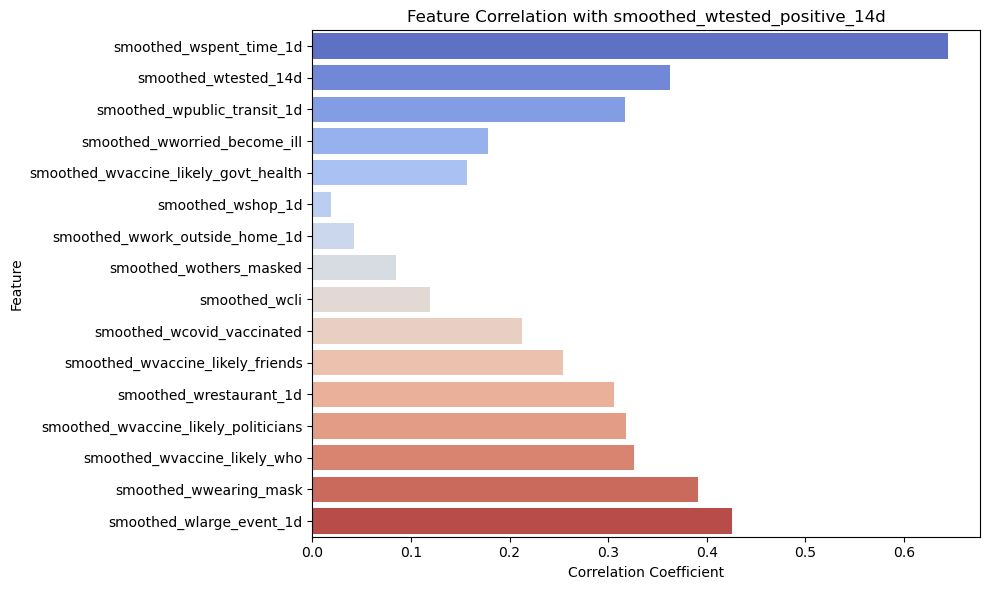


Correlation against second target variable

smoothed_wshop_1d                       0.593360
smoothed_wwork_outside_home_1d          0.493420
smoothed_wspent_time_1d                 0.414895
smoothed_wrestaurant_1d                 0.312001
smoothed_wlarge_event_1d                0.269740
smoothed_wvaccine_likely_friends        0.005683
smoothed_wpublic_transit_1d            -0.006584
smoothed_wothers_masked                -0.120322
smoothed_wtested_14d                   -0.156850
smoothed_wwearing_mask                 -0.164796
smoothed_wworried_become_ill           -0.171622
smoothed_wvaccine_likely_govt_health   -0.186620
smoothed_wvaccine_likely_who           -0.201994
smoothed_wcli                          -0.227072
smoothed_wtested_positive_14d          -0.254523
smoothed_wvaccine_likely_politicians   -0.327793
Name: smoothed_wcovid_vaccinated, dtype: float64


C:\Users\devon\AppData\Local\Temp\ipykernel_16340\347997800.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations_q2_sorted.abs().values, y=correlations_q2.index, palette='coolwarm')


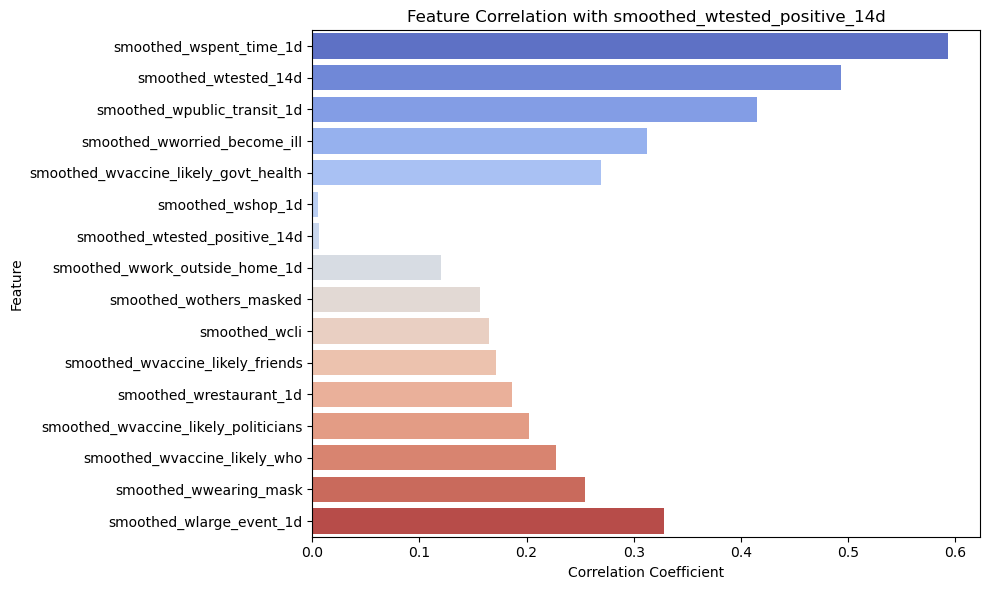

In [24]:
# Calculate VIF for each feature
vif = pd.DataFrame({
    "Feature": df.columns,
    "VIF": [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
})

print("\nVariance Inflation Factor (VIF):")
print(vif.sort_values(by="VIF", ascending=False))

# Calculate the Correlation for each Target Variable.
print('\nCorrelation against first target variable\n')
correlations_q1 = correlation_matrix['smoothed_wtested_positive_14d'].drop('smoothed_wtested_positive_14d') 

correlations_q1_sorted = correlations_q1.sort_values(ascending=False)
print(correlations_q1_sorted)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_q1_sorted.abs().values, y=correlations_q1.index, palette='coolwarm')
plt.title('Feature Correlation with smoothed_wtested_positive_14d')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print('\nCorrelation against second target variable\n')
correlations_q2 = correlation_matrix['smoothed_wcovid_vaccinated'].drop('smoothed_wcovid_vaccinated') 

correlations_q2_sorted = correlations_q2.sort_values(ascending=False)
print(correlations_q2_sorted)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_q2_sorted.abs().values, y=correlations_q2.index, palette='coolwarm')
plt.title('Feature Correlation with smoothed_wtested_positive_14d')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**The Data is preprocessed to a point where most appears normally distributed. You can see from the correlation matrix and VIF at the end we have some multicollinear relationships. I did not remove them because some of our models would do it themselves.**

In [102]:
df.to_csv("Devonte_Transformed_dataset.csv", index=False)

#For Question 1:
# Drop smoothed wtested positive 14d
x1 = df.drop('smoothed_wtested_positive_14d', axis=1)

# dataframe with only the target label. 
y1 = df['smoothed_wtested_positive_14d']

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42) #If we want to use this. 

#For Question 2: 
# Drop smoothed wcovid vaccinated
x2 = df.drop('smoothed_wcovid_vaccinated', axis=1)

# dataframe with only the target label. 
y2 = df['smoothed_wcovid_vaccinated']

x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

***Functions for Learning***

In [28]:
def linear_model(x_train, x_test, y_train, y_test):
    lr_model = LinearRegression()
    lr_model.fit(x_train, y_train)

    y_pred_lr = lr_model.predict(x_test)

    print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
    print("Linear Regression RMSE:", root_mean_squared_error(y_test, y_pred_lr))

# Want to see if there is much difference in the baseline when using cross-validation.
def cross_validated_lm(x, y, split): # x: feature variables, y: target variables, split: folds. 
    lm = LinearRegression()    
    kf = KFold(n_splits=split, shuffle=True, random_state=42)

    r2_scores = cross_val_score(lm, x, y, cv=kf, scoring="r2")
    rmse_scores = -cross_val_score(lm, x, y, cv=kf, scoring="neg_root_mean_squared_error")

    print(f"Mean R²: {r2_scores.mean():.4f}")
    print(f"Mean RMSE: {rmse_scores.mean():.4f}")

def cross_validated_Regularization(model_name, x, y, alpha, split): # model_name: Lasso or Ridge, x: features, y: targets, alpha: penalty, split: folds.

    if model_name == ElasticNet:
        model = model_name(alpha=alpha, l1_ratio=0.5)
    else:
        model = model_name(alpha=alpha)
        
    kf = KFold(n_splits=split, shuffle=True, random_state=42)

    r2_scores = cross_val_score(model, x, y, cv=kf, scoring="r2")
    rmse_scores = -cross_val_score(model, x, y, cv=kf, scoring="neg_root_mean_squared_error")
    
    return (model_name, alpha, r2_scores.mean(), rmse_scores.mean())

def best_model_description (model_name, x_train, x_test, y_train, y_test, alpha):
    if model_name == ElasticNet:
        model = model_name(alpha=alpha, l1_ratio=0.5)
    else:
        model = model_name(alpha=alpha)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    coefficients = model.coef_
    feature_weights = pd.Series(coefficients, index=x_train.columns)

    print(feature_weights.sort_values(ascending=False))

def best_model_with_pca(model_name, x_train, x_test, y_train, y_test, alpha, pca_model):
    if model_name == ElasticNet:
        model = model_name(alpha=alpha, l1_ratio=0.5)
    else:
        model = model_name(alpha=alpha)

    # Fit model and predict
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Feature importance on PCA components
    coefficients = model.coef_
    pc_names = [f"PC{i+1}" for i in range(len(coefficients))]
    feature_weights = pd.Series(coefficients, index=pc_names)

    print("\nFeature importances (sorted by weight):")
    print(feature_weights.sort_values(ascending=False))

    return model, feature_weights

Baseline Models:

In [30]:
print ("Baseline 1 Target (smoothed wtested positive 14d)")
linear_model(x1_train, x1_test, y1_train, y1_test)

print ("Baseline 2 Target (smoothed wcovid vaccinated)")
linear_model(x2_train, x2_test, y2_train, y2_test)

Baseline 1 Target (smoothed wtested positive 14d)
Linear Regression R²: 0.6117156036694975
Linear Regression RMSE: 4.612358910291211
Baseline 2 Target (smoothed wcovid vaccinated)
Linear Regression R²: 0.582592164522707
Linear Regression RMSE: 3.8560399591679344


Baseline Model using Cross-Validation

In [32]:
print ("Baseline 1 Target (smoothed wtested positive 14d)")
cross_validated_lm(x1, y1, 10) 
print ("Baseline 2 Target (smoothed wcovid vaccinated)")
cross_validated_lm(x2, y2, 10) 

Baseline 1 Target (smoothed wtested positive 14d)
Mean R²: 0.6286
Mean RMSE: 4.5189
Baseline 2 Target (smoothed wcovid vaccinated)
Mean R²: 0.5377
Mean RMSE: 4.1680


Ridge and Lasso Regression Models

In [34]:

alphas = [0.001, 0.01, 1, 10, 100] #Tuning the penalty for these models. 
models = [Lasso, Ridge, ElasticNet] #Determing which regression to use. 

best_model = None
best_alpha = None
best_r2 = None
best_rmse = float('inf')

print("First Target")
for a in alphas: 
    for m in models:
        model, alpha, r2, rmse = cross_validated_Regularization(m, x1_train, y1_train, a, 10)
        if rmse < best_rmse:
            best_model = model
            best_alpha = alpha
            best_r2 = r2
            best_rmse = rmse
            
print(f"The best model is: {best_model. __name__} with an alpha of {best_alpha}. \nR^2: {best_r2:.4f} \nRMSE: {best_rmse:.4f}")

print('\nThe coefficients for this model are:\n')

best_model_description (best_model , x1_train, x1_test, y1_train, y1_test, best_alpha)

best_model_2 = None
best_alpha_2 = None
best_r2_2 = None
best_rmse_2 = float('inf')

print("\nSecond Target\n")
for a in alphas: 
    for m in models:
        model, alpha, r2, rmse = cross_validated_Regularization(m, x2_train, y2_train, a, 10)
        if rmse < best_rmse_2:
            best_model_2 = model
            best_alpha_2 = alpha
            best_r2_2 = r2
            best_rmse_2 = rmse

print(f"The best model is: {best_model_2. __name__} with an alpha of {best_alpha_2}. \nR^2: {best_r2_2:.4f} \nRMSE: {best_rmse_2:.4f}")

print('\nThe coefficients for this model are:\n')

best_model_description (best_model_2 , x2_train, x2_test, y2_train, y2_test, best_alpha_2)

First Target
The best model is: Ridge with an alpha of 0.01. 
R^2: 0.6321 
RMSE: 4.4946

The coefficients for this model are:

smoothed_wwearing_mask                  10.351066
smoothed_wcli                            4.960262
smoothed_wvaccine_likely_politicians     0.533502
smoothed_wlarge_event_1d                 0.373462
smoothed_wworried_become_ill             0.321111
smoothed_wvaccine_likely_friends         0.260996
smoothed_wrestaurant_1d                  0.213972
smoothed_wwork_outside_home_1d           0.034709
smoothed_wvaccine_likely_who             0.033909
smoothed_wshop_1d                       -0.090049
smoothed_wspent_time_1d                 -0.179334
smoothed_wcovid_vaccinated              -0.211614
smoothed_wtested_14d                    -0.232205
smoothed_wvaccine_likely_govt_health    -0.450208
smoothed_wpublic_transit_1d             -1.489093
smoothed_wothers_masked                -11.800190
dtype: float64

Second Target

The best model is: Ridge with an alpha of 

**Feature Selection**

In [84]:
scaler_x1 = StandardScaler()
scaler_x2 = StandardScaler()

x1_train_scaled = scaler_x1.fit_transform(x1_train)
x2_train_scaled = scaler_x2.fit_transform(x2_train)


pca = PCA(n_components=0.95)  # Keep 95% of variance
x1_pca = pca.fit_transform(x1_train_scaled)
x2_pca = pca.fit_transform(x2_train_scaled)

x1_test_scaled = scaler_x1.transform(x1_test)
x2_test_scaled = scaler_x2.transform(x2_test)

pca = PCA(n_components=0.95)  # Keep 95% of variance
x1_test_pca = pca.fit_transform(x1_test_scaled)
x2_test_pca = pca.fit_transform(x2_test_scaled)

print(f"Reduced to {x1_pca.shape[1]} principal components for x1")
print(f"Reduced to {x2_pca.shape[1]} principal components for x2")

print('\nTarget Question 1')
model_q1, weights_q1 = best_model_with_pca(best_model, x1_pca, x1_test_pca, y1_train, y1_test, best_alpha, pca)

print('\nTarget Question 2')
model_q2, weights_q2 = best_model_with_pca(best_model_2, x2_pca, x2_test_pca, y2_train, y2_test, best_alpha_2, pca)

Reduced to 9 principal components for x1
Reduced to 9 principal components for x2

Target Question 1
R² Score: 0.5777
RMSE: 4.8101

Feature importances (sorted by weight):
PC3    2.678210
PC1    0.712773
PC8    0.185343
PC5   -0.108141
PC6   -0.272794
PC7   -0.409414
PC9   -1.647846
PC2   -2.101883
PC4   -3.280550
dtype: float64

Target Question 2
R² Score: 0.3894
RMSE: 4.6639

Feature importances (sorted by weight):
PC5    1.689813
PC3    1.317748
PC6    1.228069
PC8    0.801693
PC7    0.774012
PC1    0.565668
PC4   -0.684124
PC2   -2.227426
PC9   -2.228972
dtype: float64


In [100]:
# x1_pca_df = pd.DataFrame(x1_pca, columns=[f'PC{i+1}' for i in range(x1_pca.shape[1])])
# x2_pca_df = pd.DataFrame(x2_pca, columns=[f'PC{i+1}' for i in range(x2_pca.shape[1])])

# x1_test_pca_df = pd.DataFrame(x1_test_pca, columns=[f'PC{i+1}' for i in range(x1_test_pca.shape[1])])
# x2_test_pca_df = pd.DataFrame(x2_test_pca, columns=[f'PC{i+1}' for i in range(x2_test_pca.shape[1])])

# # Export to CSV
# x1_pca_df.to_csv("Devonte_x1_pca_train.csv", index=False)
# x2_pca_df.to_csv("Devonte_x2_pca_train.csv", index=False)

# x1_test_pca_df.to_csv("x1_pca_test.csv", index=False)
# x2_test_pca_df.to_csv("x2_pca_test.csv", index=False)

In [98]:
print('What comprises each pca for x1\n')
loadings_1 = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=x1_train.columns)

print(loadings_1)

print('\nWhat comprises each pca for x2\n')
loadings_2 = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=x2_train.columns)

print(loadings_2)

What comprises each pca for x1

                                           PC1       PC2       PC3       PC4  \
smoothed_wspent_time_1d               0.309295 -0.132544  0.185345 -0.079630   
smoothed_wtested_14d                 -0.234913  0.092286  0.035079  0.403042   
smoothed_wpublic_transit_1d          -0.168067 -0.185971  0.189871  0.741812   
smoothed_wworried_become_ill         -0.261984  0.167716  0.217196 -0.172941   
smoothed_wvaccine_likely_govt_health -0.302042 -0.034083  0.249285 -0.069099   
smoothed_wshop_1d                     0.194084 -0.272275  0.383356 -0.109202   
smoothed_wwork_outside_home_1d        0.118197  0.599011  0.103408 -0.150121   
smoothed_wothers_masked               0.255290 -0.148330  0.337864 -0.072696   
smoothed_wcli                        -0.263603 -0.173234 -0.031783 -0.274283   
smoothed_wcovid_vaccinated            0.082267  0.617886  0.064108  0.131922   
smoothed_wvaccine_likely_friends     -0.242076  0.046925  0.462414 -0.137426   
smoothed

**Going to try RandomForest Regressor Model Below**

In [177]:
def rf_model(x_train, y_train, estimate, depth, feature):
  
    regr = RandomForestRegressor(n_estimators=estimate, max_depth=depth, max_features=feature, random_state=42)
    regr = regr.fit(x_train, y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    r2 = cross_val_score(regr, x_train, y_train, cv=kf, scoring='r2')
    rmse = -cross_val_score(regr, x_train, y_train, cv=kf, scoring='neg_mean_squared_error')

    return (estimate, depth, feature), r2.mean(), rmse.mean()

def rf_eval(parameters, x_train, x_test, y_train, y_test):
    regr = RandomForestRegressor(n_estimators=parameters[0], max_depth=parameters[1], max_features=parameters[2], random_state=42)
    regr = regr.fit(x_train, y_train)
    regr_pred = regr.predict(x_test)
    r2 = r2_score(y_test, regr_pred)
    rmse = root_mean_squared_error(y_test, regr_pred)

    print('Evaluation Data:\nR^2: ' + str(r2) + '\nRMSE: ' + str(rmse))

In [179]:
# Took my laptop about 20 mins to run. 
estimators = [50, 100, 150] #Number of trees in the forest. 
depths = [5,10,15,20] # Determining how deep to make the model.
features = [6, 8, 10, 12] #How many features to consider when splitting.  

best_parameters = None
best_r2 = None
best_rmse = float('inf')

print("Covid Vaccine Target")
for estimate in estimators: 
    for d in depths:
        for f in features:
            parameters, r2, rmse = rf_model(x1_train, y1_train, estimate, d, f) #To preserve interpretability, I do not use my scaled features here. 
        if rmse < best_rmse:
            best_parameters = parameters 
            best_r2 = r2
            best_rmse = rmse


print('Best Parameters:' + str(best_parameters) + '\nR^2: ' + str(best_r2) + '\nRMSE: ' + str(best_rmse))

rf_eval(best_parameters, x1_train, x1_test,y1_train, y1_test)

best_parameters_2 = None
best_r2_2 = None
best_rmse_2 = float('inf')

print("Positive Cases Target")
for estimate in estimators: 
    for d in depths:
        for f in features:
            parameters, r2, rmse = rf_model(x2_train, y2_train, estimate, d, f)
        if rmse < best_rmse_2:
            best_parameters_2 = parameters 
            best_r2_2 = r2
            best_rmse_2 = rmse


print('Best Parameters:' + str(best_parameters_2) + '\nR^2: ' + str(best_r2_2) + '\nRMSE: ' + str(best_rmse_2))

rf_eval(best_parameters, x2_train, x2_test,y2_train, y2_test)

First Target
Parameters:(100, 5, 8)
R^2: 0.6348152347782519
RMSE: 20.121355020295013
Evaluation Data:
R^2: 0.6297575165040313
RMSE: 4.503926043663138
Second Target
Parameters:(100, 5, 8)
R^2: 0.5954293863992269
RMSE: 15.401716898582546
Evaluation Data:
R^2: 0.6036067511073043
RMSE: 3.757719441586316


                                 Feature  Importance
8                          smoothed_wcli    0.342219
7                smoothed_wothers_masked    0.115471
2            smoothed_wpublic_transit_1d    0.076371
15              smoothed_wlarge_event_1d    0.063721
9             smoothed_wcovid_vaccinated    0.058395
3           smoothed_wworried_become_ill    0.049601
11               smoothed_wrestaurant_1d    0.044621
1                   smoothed_wtested_14d    0.040417
12  smoothed_wvaccine_likely_politicians    0.035978
5                      smoothed_wshop_1d    0.030148


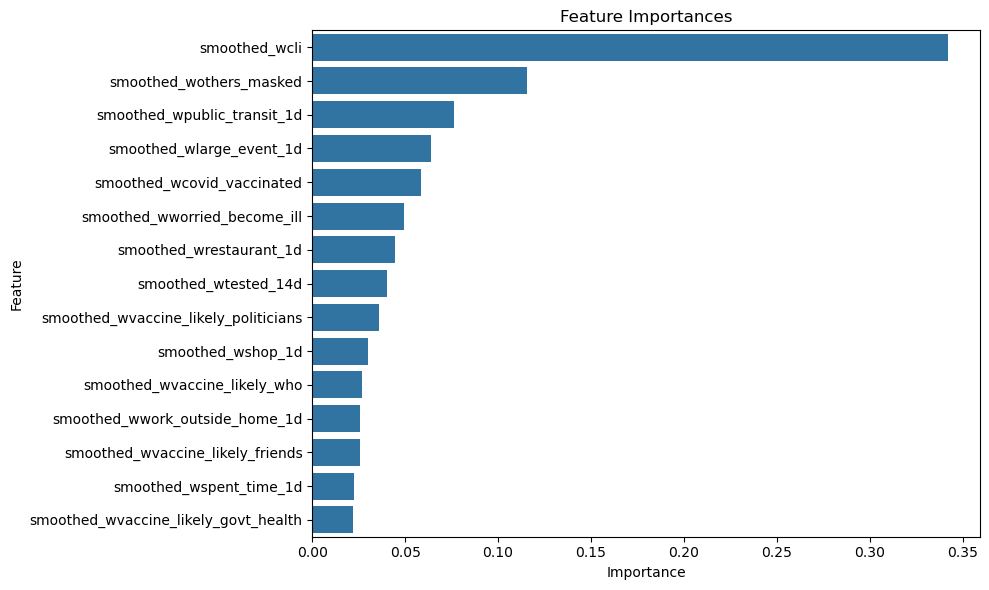

                                 Feature  Importance
5                      smoothed_wshop_1d    0.338071
7         smoothed_wwork_outside_home_1d    0.105886
6          smoothed_wtested_positive_14d    0.078717
8                smoothed_wothers_masked    0.062890
10      smoothed_wvaccine_likely_friends    0.058795
3           smoothed_wworried_become_ill    0.049311
12  smoothed_wvaccine_likely_politicians    0.046582
1                   smoothed_wtested_14d    0.039673
11               smoothed_wrestaurant_1d    0.031441
9                          smoothed_wcli    0.030546


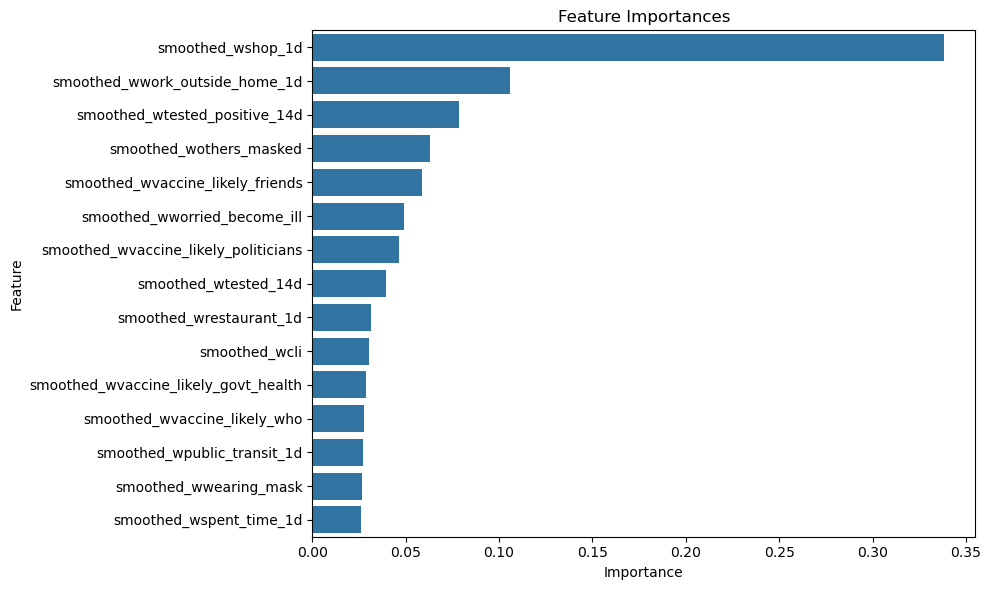

In [130]:
regr = RandomForestRegressor(n_estimators=120, max_depth=20, max_features=12, random_state=42)
regr.fit(x1_train, y1_train)

importances = regr.feature_importances_

# Combine with column names
feature_names = x1_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


regr = RandomForestRegressor(n_estimators=120, max_depth=20, max_features=12, random_state=42)
regr.fit(x2_train, y2_train)

importances_2 = regr.feature_importances_

# Combine with column names
feature_names_2 = x2_train.columns
feature_importance_df_2 = pd.DataFrame({
    'Feature': feature_names_2,
    'Importance': importances_2
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df_2.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_2.head(15))
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

In [149]:
# Read and Clean in Justin's EDA. 

def read_clean_csv(filepath):
    df = pd.read_csv(filepath)
    # Drop first column if it's unnamed (usually an index column)
    if df.columns[0].startswith('Unnamed'):
        df = df.iloc[:, 1:]
    return df

cvf_test = read_clean_csv('cv_features_test.csv')
cvf_train = read_clean_csv('cv_features_train.csv')
cvf_val = read_clean_csv('cv_features_val.csv')
cvt_test = read_clean_csv('cv_target_test.csv')
cvt_train = read_clean_csv('cv_target_train.csv')
cvt_val = read_clean_csv('cv_target_val.csv')
tpf_test = read_clean_csv('tp_features_test.csv')
tpf_train = read_clean_csv('tp_features_train.csv')
tpf_val = read_clean_csv('tp_features_val.csv')
tpt_test = read_clean_csv('tp_target_test.csv')
tpt_train = read_clean_csv('tp_target_train.csv')
tpt_val = read_clean_csv('tp_target_val.csv')

In [185]:
# For covid vaccine

regr = RandomForestRegressor(n_estimators=120, max_depth=20,random_state = 42)
regr.fit(cvf_train, cvt_train)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2 = cross_val_score(regr, cvf_train, cvt_train, cv=kf, scoring='r2')
rmse = -cross_val_score(regr, cvf_train, cvt_train, cv=kf, scoring='neg_mean_squared_error')

print('\nR^2: ' + str(r2.mean()) + '\nRMSE: ' + str(rmse.mean()))

regr_pred = regr.predict(cvf_test)
r2 = r2_score(cvt_test, regr_pred)
rmse = root_mean_squared_error(cvt_test, regr_pred)

print('Evaluation Data:\nR^2: ' + str(r2) + '\nRMSE: ' + str(rmse))

importances = regr.feature_importances_

feature_names = cvf_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

C:\Users\devon\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\devon\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\devon\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\devon\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for


R^2: 0.40391069458205653
RMSE: 26.52827639571658
Evaluation Data:
R^2: 0.4086252766123424
RMSE: 5.186345804753729


In [ ]:
# For Positive COVID Rate

regr = RandomForestRegressor(n_estimators=120, max_depth=20,random_state = 42)
regr.fit(tpf_train, tpt_train)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2 = cross_val_score(regr, tpf_train, tpt_train, cv=kf, scoring='r2')
rmse = -cross_val_score(regr, tpf_train, tpt_train, cv=kf, scoring='neg_mean_squared_error')

print('\nR^2: ' + str(r2.mean()) + '\nRMSE: ' + str(rmse.mean()))

regr_pred = regr.predict(tpf_test)
r2 = r2_score(tpt_test, regr_pred)
rmse = root_mean_squared_error(tpt_test, regr_pred)

print('Evaluation Data:\nR^2: ' + str(r2) + '\nRMSE: ' + str(rmse))

importances = regr.feature_importances_

feature_names = tpf_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()